In [4]:
import sys
sys.path.insert(0, '../../../../build/python')

from tqdm import trange

import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt

import drjit as dr
import mitsuba as mi

mi.set_variant('cuda_ad_rgb')

# Constants for training
SUN_PHI = 0
ALBEDO = 0.5
MIN_ETA = dr.deg2rad(2)
MAX_ETA = dr.deg2rad(88)

## Setup optimization

In [5]:
""" Function that we want to fit"""
def get_lum(sky_rad, sky_params, cos_theta, gamma):
    cos_gamma = dr.cos(gamma)
    cos_gamma_2 = cos_gamma * cos_gamma

    res = dr.copy(sky_rad)
    for channel_idx in range(3):
        c1 = 1 + sky_params[channel_idx * 9 + 0] * dr.exp(sky_params[channel_idx * 9 + 1] / (cos_theta + 0.01))
        chi = (1 + cos_gamma_2) / ((1 + sky_params[channel_idx * 9 + 8]**2 - 2 * sky_params[channel_idx * 9 + 8] * cos_gamma)**1.5)
        c2 = sky_params[channel_idx * 9 + 2] + sky_params[channel_idx * 9 + 3] * dr.exp(sky_params[channel_idx * 9 + 4] * gamma) + \
                sky_params[channel_idx * 9 + 5] * cos_gamma_2 + sky_params[channel_idx * 9 + 6] * chi + sky_params[channel_idx * 9 + 7] * dr.safe_sqrt(cos_theta)

        res[channel_idx] *= c1 * c2
    
    return mi.luminance(res) * mi.MI_CIE_Y_NORMALIZATION & (cos_theta > 0)

In [6]:
""" Computes the normalization factor for the luminance function above """

@dr.syntax
def integrate_luminance(sun_dir, sky_rad, sky_params, cos_thetas, phis, quad_weights):

    i = mi.UInt32(0)
    total_lum = mi.Float(0)
    while i < dr.width(cos_thetas):
        # Gather inputs
        ct = dr.gather(mi.Float, cos_thetas, i)
        phi = dr.gather(mi.Float, phis, i)
        weight = dr.gather(mi.Float, quad_weights, i)

        # Compute direction
        st = dr.safe_sqrt(1 - ct**2)
        sp, cp = dr.sincos(phi)
        dir = mi.Vector3f(st * cp, st * sp, ct)
        gamma = dr.unit_angle(dir, sun_dir)

        res = get_lum(sky_rad, sky_params, ct, gamma)
        total_lum += weight * res
        i += 1
    
    return total_lum

def compute_norm_factor(sun_dir, sky_rad, sky_params):
    quad_points, quad_weights = mi.quad.gauss_legendre(200)
    cos_theta = quad_points * 0.5 + 0.5
    phi = dr.pi * (quad_points + 1)
    cos_theta, phi = dr.meshgrid(cos_theta, phi)
    phi_weights, cos_theta_weights = dr.meshgrid(quad_weights, quad_weights)
    weights = 0.5 * dr.pi * cos_theta_weights * phi_weights

    return dr.rcp(integrate_luminance(sun_dir, sky_rad, sky_params, cos_theta, phi, weights))

In [7]:
def load_tensors(file_path):
    tensors = mi.tensor_io.read(file_path)

    sky_rad = tensors[f"sky_rad_{'rgb' if mi.is_rgb else 'spec'}"]
    sky_params = tensors[f"sky_params_{'rgb' if mi.is_rgb else 'spec'}"]

    return mi.TensorXf(sky_rad), mi.TensorXf(sky_params)

@dr.syntax
def interpolate_dataset(dataset, albedo, turb_, eta_):
    dataset = dr.take_interp(dataset, albedo, axis=1)

    eta = (2. * eta_ * dr.inv_pi) ** (1/3)
    turb = turb_ - 1

    turb0 = mi.UInt32(dr.floor(turb))
    dturb = dr.clip(turb - turb0, 0, 1)

    bezier_coefs = dr.alloc_local(mi.Float, 6, mi.Float(0))
    for i, coef in enumerate((1, 5, 10, 10, 5, 1)):
        bezier_coefs[i] = mi.ScalarFloat(coef)
    
    res_shape = (dr.prod(dataset.shape[2:]), dr.width(turb_))
    res = dr.zeros(mi.ArrayXf, shape=res_shape)

    idx = mi.UInt32(0)
    while idx < 6:
        turb_low = dr.gather(mi.ArrayXf, dataset.array, turb0 * 6 + idx, shape=res_shape)
        turb_high = dr.gather(mi.ArrayXf, dataset.array, (turb0 + 1) * 6 + idx, active=turb0+1<=9, shape=res_shape)

        temp = dr.lerp(turb_low, turb_high, dturb)
        res += temp * (eta**idx) * ((1 - eta)**(5 - idx)) * bezier_coefs[idx]

        idx += 1

    return res

def init_optimization_vars(sky_rad_dataset, sky_params_dataset, turb_res=10, sun_eta_res=30):

    # Define grid of turbidity and sun elevation angles
    turbs = dr.linspace(mi.Float, 1.0, 10.0, turb_res)
    sun_etas = dr.linspace(mi.Float, MIN_ETA, MAX_ETA, sun_eta_res)
    turbs, sun_etas = dr.meshgrid(turbs, sun_etas)
    tex_pos = mi.Point2f((turbs - 1) / (10 - 1), (sun_etas - MIN_ETA) / (MAX_ETA - MIN_ETA))

    # Precompute sky radiance and parameters for each (turbidity, sun_eta) pair
    sky_rad = interpolate_dataset(sky_rad_dataset, ALBEDO, turbs, sun_etas)
    sky_params = interpolate_dataset(sky_params_dataset, ALBEDO, turbs, sun_etas)

    sky_rad = mi.Color3f(sky_rad)

    # Compute sun direction for each (turbidity, sun_eta) pair
    sun_thetas = dr.pi / 2 - sun_etas
    st, ct = dr.sincos(sun_thetas)
    sp, cp = dr.sincos(SUN_PHI)
    sun_dir = mi.Vector3f(st * cp, st * sp, ct)

    dr.eval(sky_rad, sky_params, sun_dir, tex_pos)

    # Compute normalization factor for each (turbidity, sun_eta) pair
    norm_factor = compute_norm_factor(sun_dir, sky_rad, sky_params)
    dr.eval(norm_factor)


    return sky_rad, sky_params, sun_dir, tex_pos, norm_factor

In [9]:
TRAINING_TURB_RES = 180
TRAINING_SUN_ETA_RES = 3*TRAINING_TURB_RES

## Generate rays to evaluate luminance map
lum_map_res = (300, 75)
phis, thetas = dr.meshgrid(
    dr.linspace(mi.Float, 0, 2 * dr.pi, lum_map_res[0]),
    dr.linspace(mi.Float, 0.01 * dr.pi, dr.pi / 2 + 0.001 * dr.pi, lum_map_res[1])
)
st, ct = dr.sincos(thetas)
sp, cp = dr.sincos(phis)
env_map_wi = mi.Vector3f(st * cp, st * sp, ct)
dr.eval(env_map_wi)

sky_rad_dataset, sky_params_dataset = load_tensors('../output/sunsky_datasets.bin')

sky_rad, sky_params, sun_dir, tex_pos, norm_factor = init_optimization_vars(
    sky_rad_dataset, sky_params_dataset,
    turb_res=TRAINING_TURB_RES, sun_eta_res=TRAINING_SUN_ETA_RES
)


Loading tensor data from "../output/sunsky_datasets.bin" .. (540.0 KiB, 7 fields)


### Vizalize a few luminance maps to check all is ok

In [10]:
def viz_sky_map(sun_dir, sky_rad, sky_params, norm_factor, idx):

    sun_dir = dr.gather(mi.Vector3f, sun_dir, idx)
    sky_rad = dr.gather(mi.Color3f, sky_rad, idx)
    sky_params = dr.gather(mi.ArrayXf, sky_params, idx, shape=(3 * 9, 1))
    norm_factor = dr.gather(mi.Float, norm_factor, idx)

    gamma = dr.unit_angle(env_map_wi, sun_dir)

    pdf = get_lum(sky_rad, sky_params, ct, gamma) * norm_factor
    return mi.TensorXf(pdf, shape=lum_map_res[::-1])

In [11]:
def trunc_gaussian_pdf(mean, sigma, a, b, x):
    cdf_a = 0.5 * (1 + dr.erf(dr.inv_sqrt_two * (a - mean) / sigma))
    cdf_b = 0.5 * (1 + dr.erf(dr.inv_sqrt_two * (b - mean) / sigma))

    volume = (cdf_b.x - cdf_a.x) * (cdf_b.y - cdf_a.y) * (sigma.x * sigma.y)
    return mi.warp.square_to_std_normal_pdf((x - mean) / sigma) / volume

def warp_1_pdf(weight, uv):
    """ 
    First warp: maps samples in (cos(theta), phi) space lower on the horizon
    """
    return dr.rcp(weight * dr.power(1 + uv.x*uv.x*(1/(weight**2) - 1), 1.5))

def warp_2_pdf(weights, uv):
    """ 
    Second warp: maps samples in (cos(theta), phi) space towards the sun direction with a gaussian warp
    """
    mean = mi.Point2f(weights[0], SUN_PHI)
    sigma = mi.Point2f(weights[1], weights[2])

    pdf = trunc_gaussian_pdf(mean, sigma, 
            mi.ScalarPoint2f(0.0, -dr.pi), 
            mi.ScalarPoint2f(1.0, dr.pi), uv
    )

    return pdf


def approximate_pdf(tex_weights, tex_pos, uv):
    """ Function we will use to approximate the PDF
        arguments:
            weights: list of weights for the warp
            uv: (cos_theta, phi) coordinates of the point where to evaluate the PDF
        returns:
            approximated PDF value at the given point
    """
    weights = tex_weights.eval(tex_pos)

    pdf1 = warp_1_pdf(weights[1], uv)
    pdf2 = warp_2_pdf(weights[2:], uv)

    valid_range = (0 <= uv.x) & (uv.x <= 1)
    return dr.lerp(dr.inv_two_pi * pdf1, pdf2, weights[0]) & valid_range

def train_approx_pdf(weights, tex_pos, uv):
    pdf1 = warp_1_pdf(weights[1], uv)
    pdf2 = warp_2_pdf(weights[2:], uv)

    valid_range = (0 <= uv.x) & (uv.x <= 1)
    return dr.lerp(dr.inv_two_pi * pdf1, pdf2, weights[0]) & valid_range


def uniform_pdf(tex_weights, tex_pos, uv):
    """ Uniform PDF over the sphere """
    valid_range = (0 <= uv.x) & (uv.x <= 1)
    return dr.inv_two_pi & valid_range

def tgmm_pdf(tex_weights, tex_pos, uv):
    """ 
    TGMM-based PDF
    arguments:
        weights: list of weights for the warp
        uv: (cos_theta, phi) coordinates of the point where to evaluate the PDF
    returns:
        approximated PDF value at the given point
    """
    turb = tex_pos.x * (10 - 1) + 1
    sun_eta = dr.rad2deg(tex_pos.y * (MAX_ETA - MIN_ETA) + MIN_ETA)

    turb_idx = dr.clip(turb - 2, 0, 8)
    sun_eta_idx = dr.clip((sun_eta - 2) / 3, 0, 29)

    turb_idx = dr.uint32_array_t(turb_idx)(dr.round(turb_idx))
    sun_eta_idx = dr.uint32_array_t(sun_eta_idx)(dr.round(sun_eta_idx))

    tgmm_start_idx = turb_idx * 30 + sun_eta_idx
    weights = dr.gather(mi.ArrayXf, tex_weights.array, tgmm_start_idx, shape=(25, 1))

    phi, theta = uv.y, dr.acos(uv.x)
    phi -= SUN_PHI - 0.5*dr.pi
    phi = dr.select(phi < 0, phi + dr.two_pi, phi)
    new_uv = mi.Point2f(phi, theta)

    pdf = 0
    for i in range(5):
        mean = mi.Point2f(weights[5*i+0], weights[5*i+1])
        sigma = mi.Point2f(weights[5*i+2], weights[5*i+3])

        pdf += weights[5*i+4] * trunc_gaussian_pdf(mean, sigma, 
            mi.ScalarPoint2f(0.0,       0), 
            mi.ScalarPoint2f(dr.two_pi, 0.5 * dr.pi), new_uv
        )

    st = dr.safe_sqrt(1 - uv.x * uv.x)
    return (pdf / dr.maximum(st, dr.epsilon(mi.Float))) & (0 <= uv.x) & (uv.x <= 1)

In [12]:
def init_optimised_weights(turb_res, sun_eta_res):
    rng = dr.rng(42)
    weight = rng.normal(mi.TensorXf, shape=(sun_eta_res, turb_res, 1), loc=0.2, scale=0.05)
    horizon_warp = rng.normal(mi.TensorXf, shape=(sun_eta_res, turb_res, 1), loc=0.8, scale=0.01)
    turbs, sun_elevation = dr.meshgrid(
        dr.linspace(mi.Float, 1, 10, turb_res),
        dr.linspace(mi.Float, MIN_ETA, MAX_ETA, sun_eta_res),
        indexing='xy'
    )
    cos_sun_elevation = mi.TensorXf(dr.cos(dr.pi/2 - sun_elevation), shape=(sun_eta_res, turb_res, 1))
    #cos_sun_elevation = rng.normal(mi.TensorXf, shape=(sun_eta_res, turb_res, 1), loc=0.5, scale=0.1)
    
    sun_sigma = dr.full(mi.TensorXf, 0.1, shape=(sun_eta_res, turb_res, 2))
    return dr.concat((weight, horizon_warp, cos_sun_elevation, sun_sigma), axis=2)

def clamp_channels(weights, channel_idx, min_val=-dr.inf, max_val=dr.inf):
    """ Clamps the weights to avoid numerical issues during optimization """
    idx = dr.arange(mi.UInt32, dr.prod(weights.shape[:-1])) * weights.shape[-1] + channel_idx
    channel_weights = dr.gather(mi.Float, weights.array, idx)
    clamped_weights = dr.clip(channel_weights, min_val, max_val)
    dr.scatter(weights.array, clamped_weights, idx)

    return weights


In [13]:
@dr.syntax
def accumulate_on_grid(accum_func, approximate_pdf, tex_weights, tex_pos, sky_rad, sky_params, norm_factor, sun_dir, wi, nb_wi):

    ray_idx = mi.UInt32(0)
    total_loss = mi.Float(0)
    while dr.hint(ray_idx < nb_wi, max_iterations=-1):
        direction = dr.gather(mi.Vector3f, wi, ray_idx)
        cos_theta = mi.Frame3f.cos_theta(direction)
        phi = dr.atan2(direction.y, direction.x)
        gamma = dr.unit_angle(direction, sun_dir)

        target_pdf = get_lum(sky_rad, sky_params, cos_theta, gamma) * norm_factor
        approx_pdf = approximate_pdf(tex_weights, tex_pos, mi.Point2f(cos_theta, phi))
        
        total_loss += accum_func(approx_pdf, target_pdf)

        ray_idx += 1

    return total_loss / nb_wi

def compute_loss_grid(approximate_pdf, tex_weights, tex_pos, sky_rad, sky_params, norm_factor, sun_dir, wi, nb_wi):
    return accumulate_on_grid(
        lambda approx_pdf, target_pdf: (approx_pdf - target_pdf) ** 2,
        approximate_pdf,
        tex_weights, tex_pos, sky_rad, sky_params, norm_factor, sun_dir, wi, nb_wi
    )

def compute_mre_grid(approximate_pdf, tex_weights, tex_pos, sky_rad, sky_params, norm_factor, sun_dir, wi, nb_wi):
    return accumulate_on_grid(
        lambda approx_pdf, target_pdf: dr.abs(approx_pdf - target_pdf) / dr.maximum(target_pdf, dr.epsilon(mi.Float)),
        approximate_pdf,
        tex_weights, tex_pos, sky_rad, sky_params, norm_factor, sun_dir, wi, nb_wi
    )

def compute_loss(tex_weights, tex_pos, sky_rad, sky_params, norm_factor, sun_dir, wi, nb_wi):
    weights = tex_weights.eval(tex_pos)

    # MSE
    loss = compute_loss_grid(
        train_approx_pdf,
        weights, tex_pos, sky_rad, sky_params, norm_factor, sun_dir, wi, nb_wi
    )

    ## Regularizer
    regularizer = mi.Float(0)
    # # keep a downward warp towards the horizon
    regularizer += 50*dr.select(
        weights[1] > 1, (1 - weights[1])**2, 0
    )

    # keep the mean arround the sun elevation
    # real_sun_elevation = dr.cos(dr.pi/2 - tex_pos.y * (MAX_ETA - MIN_ETA) + MIN_ETA)
    # err = real_sun_elevation - weights[2]
    # regularizer += 0.05 * err ** 2
    regularizer = (dr.clip(weights[2], 0.0, 1.0) - weights[2])**2

    # prevent the gaussian from flattening too much
    regularizer += dr.select(
        weights[3] > 1, (weights[3] - 1)**2, 0
    )
    regularizer += dr.select(
        weights[4] > dr.two_pi, (weights[4] - dr.two_pi)**2, 0
    )


    dr.backward(loss + regularizer)

    return dr.mean(loss)

Optimizing: 100%|██████████| 13000/13000 [09:54<00:00, 21.86it/s, Loss: [0.000740973]]


Loading tensor data from "../output/sampling_data.bin" .. (31.8 KiB, 3 fields)
Wrote "../output/sampling_data.bin" (31.8 KiB)


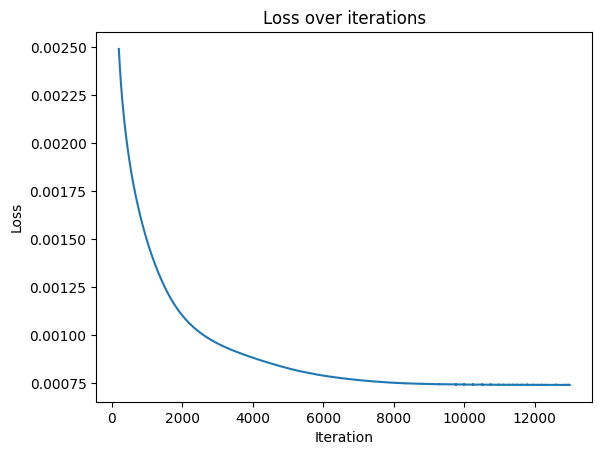

In [21]:
## Generate initial weights

if True:
    opt_key = "weights"

    if False:
        weights = mi.tensor_io.read('../output/sampling_data.bin')['weights']
        weights = mi.TensorXf(weights)
        tex_weights = mi.Texture2f(weights, 
                                wrap_mode=dr.WrapMode.Clamp,
                                migrate=False)
    else:
        turb_res = 10
        sun_eta_res = 30

        weights = init_optimised_weights(turb_res, sun_eta_res)
        tex_weights = mi.Texture2f(weights, 
                                wrap_mode=dr.WrapMode.Clamp,
                                migrate=False)

    opt = mi.ad.Adam(lr=0.005)
    opt[opt_key] = weights

    def update_and_clamp_weights(optimizer, tex_weights):

        tensor = clamp_channels(optimizer[opt_key], 0, min_val=0, max_val=1)
        tensor = clamp_channels(tensor, 1, min_val=0, max_val=1)


        optimizer[opt_key] = tensor
        tex_weights.set_tensor(optimizer[opt_key])

    ## Optimize
    losses = []
    iterations = trange(13000, desc="Optimizing")
    for it in iterations:

        update_and_clamp_weights(opt, tex_weights)

        loss = compute_loss(tex_weights, tex_pos, sky_rad, sky_params, norm_factor, sun_dir, env_map_wi, dr.width(env_map_wi))

        opt.step()

        if it % 5 == 0:
            iterations.set_postfix_str(f"Loss: {loss}")

        losses.append(loss)

    update_and_clamp_weights(opt, tex_weights)
    optimal_weights = opt[opt_key]

    ### Save optimized weights
    old_tensors = mi.tensor_io.read('../output/sampling_data.bin')
    old_tensors[opt_key] = optimal_weights
    mi.tensor_io.write('../output/sampling_data.bin', **old_tensors)

    plt.close()
    cutoff = 200
    losses_to_plot = losses[cutoff:]
    plt.plot(np.arange(len(losses_to_plot)) + cutoff, losses_to_plot)
    plt.title('Loss over iterations')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.show()

## Plot results

In [15]:
def show_im(fig, im, ax, title, xlabel='', ylabel=''):
    im = ax.imshow(im, origin='lower', 
                extent=[1.0, 10.0, 2.0, 88.0], aspect='auto')
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    fig.colorbar(im, ax=ax)

def plot_mre(pdf_funcs):
    fig, axs = plt.subplots(1, len(pdf_funcs), figsize=(16, 5), sharey=True)

    for ax, (pdf_name, (pdf_func, tex_weights)) in zip(axs, pdf_funcs.items()):
        pdf_func = compute_mre_grid(
            pdf_func, tex_weights, tex_pos, sky_rad, sky_params, norm_factor, sun_dir, env_map_wi, dr.width(env_map_wi)
        )
        im = mi.TensorXf(pdf_func, shape=(TRAINING_SUN_ETA_RES, TRAINING_TURB_RES))
        show_im(fig, im, ax, pdf_name, xlabel='Turbidity')

    axs[0].set_ylabel('Sun elevation (deg)')

    fig.suptitle('Mean Relative Error over the grid', fontsize='x-large')
    fig.tight_layout()
    return fig


def plot_weights(tex_weights):
    weights = tex_weights.tensor()
    fig, axs = plt.subplots(3, 2, figsize=(16, 10), sharex=True, sharey=True)

    show_im(fig, weights[..., 0], axs[0,0], 'Pick Gaussian weight', ylabel='Sun Elevation (degrees)')
    show_im(fig, weights[..., 1], axs[0,1], 'Horizon warp weight')
    show_im(fig, weights[..., 3], axs[1,0], 'Sun elevation sigma',ylabel='Sun Elevation (degrees)', xlabel='Turbidity')
    show_im(fig, weights[..., 4], axs[1,1], 'Sun azimuth sigma', xlabel='Turbidity')
    show_im(fig, weights[..., 2], axs[2,0], 'Cosine of Gaussian mean (sun elevation)', ylabel='Sun Elevation (degrees)', xlabel='Turbidity')

    fig.delaxes(axs[2,1])
    fig.suptitle('Weights per gridpoint', fontsize='x-large')

    fig.tight_layout()
    return fig

def plot_pdf(fig, pdf_func, tex_weights, chosen_point):
    axs = fig.subplots(1, 2, sharey=True)

    chosen_tex_pos = dr.gather(mi.Point2f, tex_pos, chosen_point)

    # Target pdf
    target_pdf = viz_sky_map(sun_dir, sky_rad, sky_params, norm_factor, chosen_point)

    # Approximate pdf
    cos_theta = mi.Frame3f.cos_theta(env_map_wi)
    phi = dr.atan2(env_map_wi.y, env_map_wi.x)

    approx_pdf = pdf_func(tex_weights, chosen_tex_pos, mi.Point2f(cos_theta, phi))
    approx_pdf = mi.TensorXf(approx_pdf, shape=lum_map_res[::-1])

    vmin = dr.minimum(dr.min(target_pdf), dr.min(approx_pdf))
    vmax = dr.maximum(dr.max(target_pdf), dr.max(approx_pdf))

    axs[0].set_title('Target sky pdf')
    axs[0].set_xlabel('Azimuth (deg)')
    axs[0].set_ylabel('Elevation (deg)')
    axs[0].imshow(target_pdf, origin='upper', 
                extent=[0, 360, 0, 90], aspect='auto', vmin=vmin, vmax=vmax)

    axs[1].set_title('Approximate sky pdf')
    axs[1].set_xlabel('Azimuth (deg)')
    axs[1].imshow(approx_pdf, origin='upper', 
                extent=[0, 360, 0, 90], aspect='auto', vmin=vmin, vmax=vmax)

    point = (chosen_tex_pos.x * 9 + 1, chosen_tex_pos.y * (MAX_ETA - MIN_ETA) + MIN_ETA)

    fig.suptitle(f'Chosen pdf plot: {point[0]} turbidity and {dr.rad2deg(point[1])}° sun elevation', fontsize='x-large')

#### We choose the points where we want to see the luminace map and the approximation

In [17]:
optimal_weights = mi.tensor_io.read('../output/sampling_data.bin')['weights']
tex_weights = mi.Texture2f(optimal_weights, 
                        wrap_mode=dr.WrapMode.Clamp,
                        migrate=False)

weights = tex_weights.eval(tex_pos)
losses_per_point = compute_loss_grid(
    approximate_pdf,
    tex_weights, tex_pos, sky_rad, sky_params, norm_factor, sun_dir, env_map_wi, dr.width(env_map_wi)
)
rel_err_per_point = compute_mre_grid(
    approximate_pdf,
    tex_weights, tex_pos, sky_rad, sky_params, norm_factor, sun_dir, env_map_wi, dr.width(env_map_wi)
)

losses_per_point = mi.TensorXf(losses_per_point, shape=(TRAINING_SUN_ETA_RES, TRAINING_TURB_RES))
rel_err_per_point = mi.TensorXf(rel_err_per_point, shape=(TRAINING_SUN_ETA_RES, TRAINING_TURB_RES))


chosen_points = []
if True:
    data = rel_err_per_point

    data_idx = np.argmin(data)
    turb_val = (data_idx % TRAINING_TURB_RES) / (TRAINING_TURB_RES - 1) * 9 + 1
    sun_eta_idx = (data_idx // TRAINING_TURB_RES) / (TRAINING_SUN_ETA_RES - 1) * (MAX_ETA - MIN_ETA) + MIN_ETA
    chosen_points.append((data_idx, f"Point of min relative error:\nturb = {turb_val:.2f}, sun elevation = {dr.rad2deg(sun_eta_idx):.2f}°"))

    data_idx = np.argmax(data)
    turb_val = (data_idx % TRAINING_TURB_RES) / (TRAINING_TURB_RES - 1) * 9 + 1
    sun_eta_idx = (data_idx // TRAINING_TURB_RES) / (TRAINING_SUN_ETA_RES - 1) * (MAX_ETA - MIN_ETA) + MIN_ETA
    chosen_points.append((data_idx, f"Point of max relative error:\nturb = {turb_val:.2f}, sun elevation = {dr.rad2deg(sun_eta_idx):.2f}°"))
    #chosen_point = np.argmax(rel_err_per_point)
else:
    chosen_turb = 10
    chosen_sun_eta = dr.deg2rad(30)
    chosen_turb_idx = dr.round(((chosen_turb - 1) / 9) * (TRAINING_TURB_RES - 1))
    chosen_sun_eta_idx = dr.round(((chosen_sun_eta - MIN_ETA) / (MAX_ETA - MIN_ETA)) * (TRAINING_SUN_ETA_RES - 1))
    chosen_point = chosen_sun_eta_idx * TRAINING_TURB_RES + chosen_turb_idx
    chosen_points.append((chosen_point, f"Chosen point at turb = {chosen_turb:.2f}, sun elevation = {dr.rad2deg(chosen_sun_eta):.2f}°"))

Loading tensor data from "../output/sampling_data.bin" .. (31.8 KiB, 3 fields)


#### Load the TGMM weights for comparison

Loading tensor data from "../output/tgmm_tables.bin" .. (26.4 KiB, 1 field)


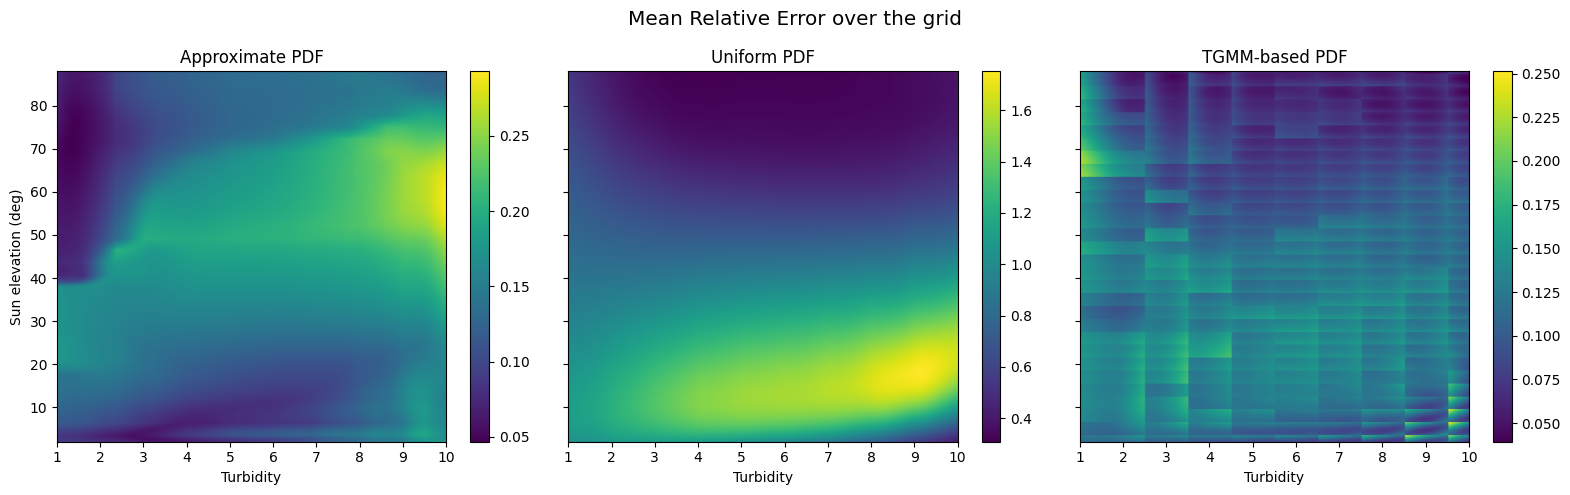

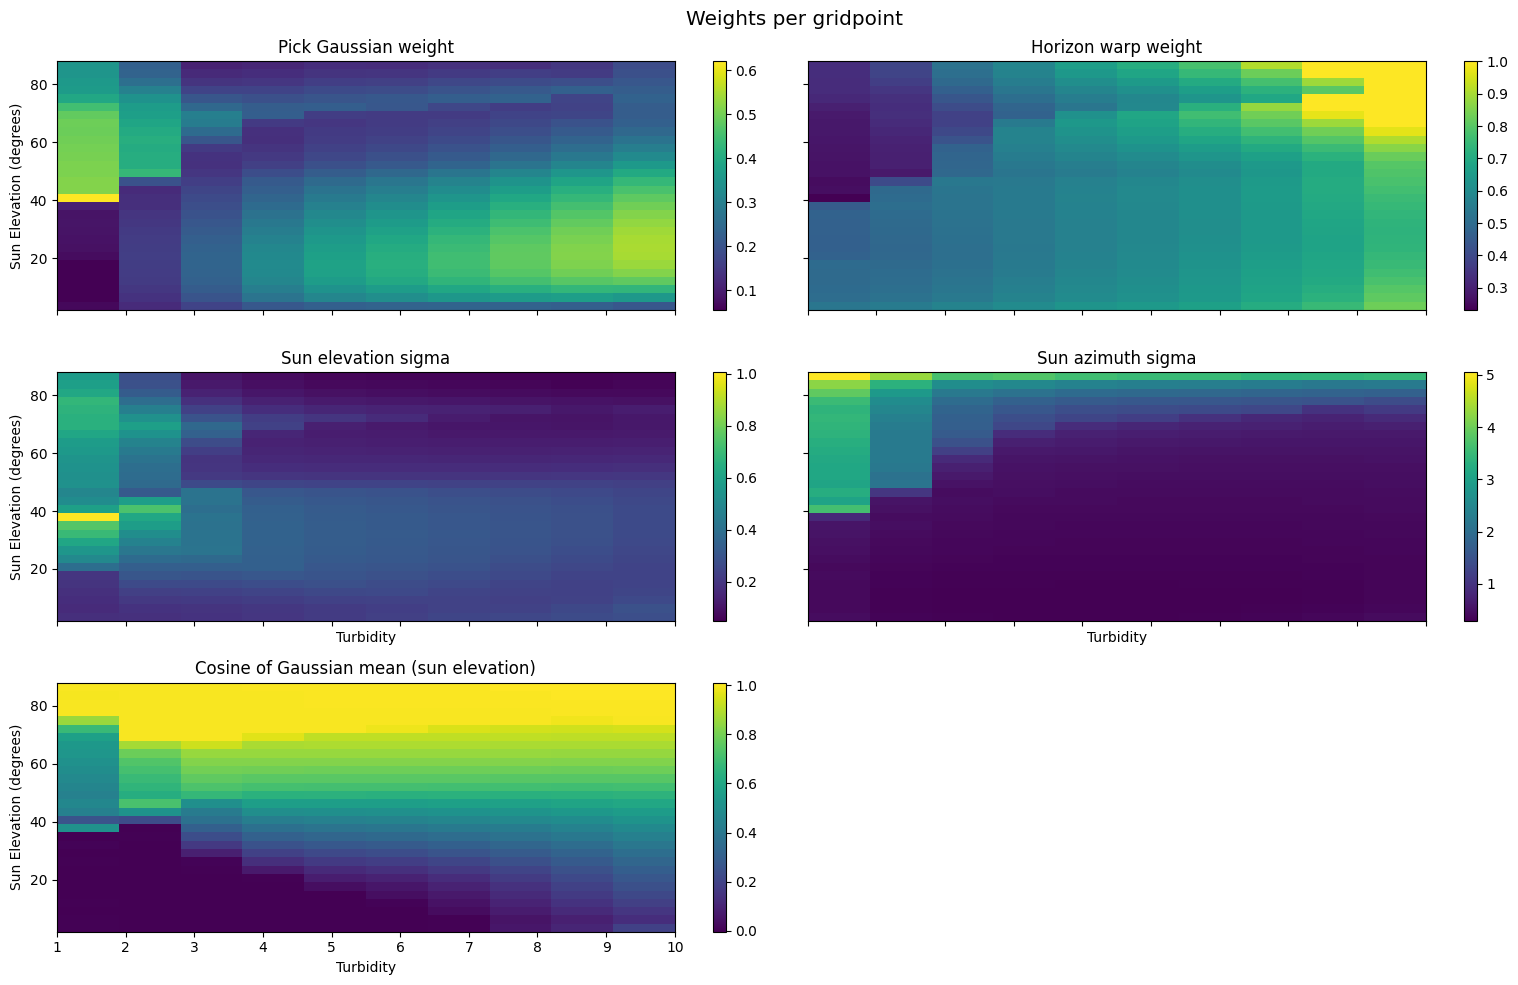

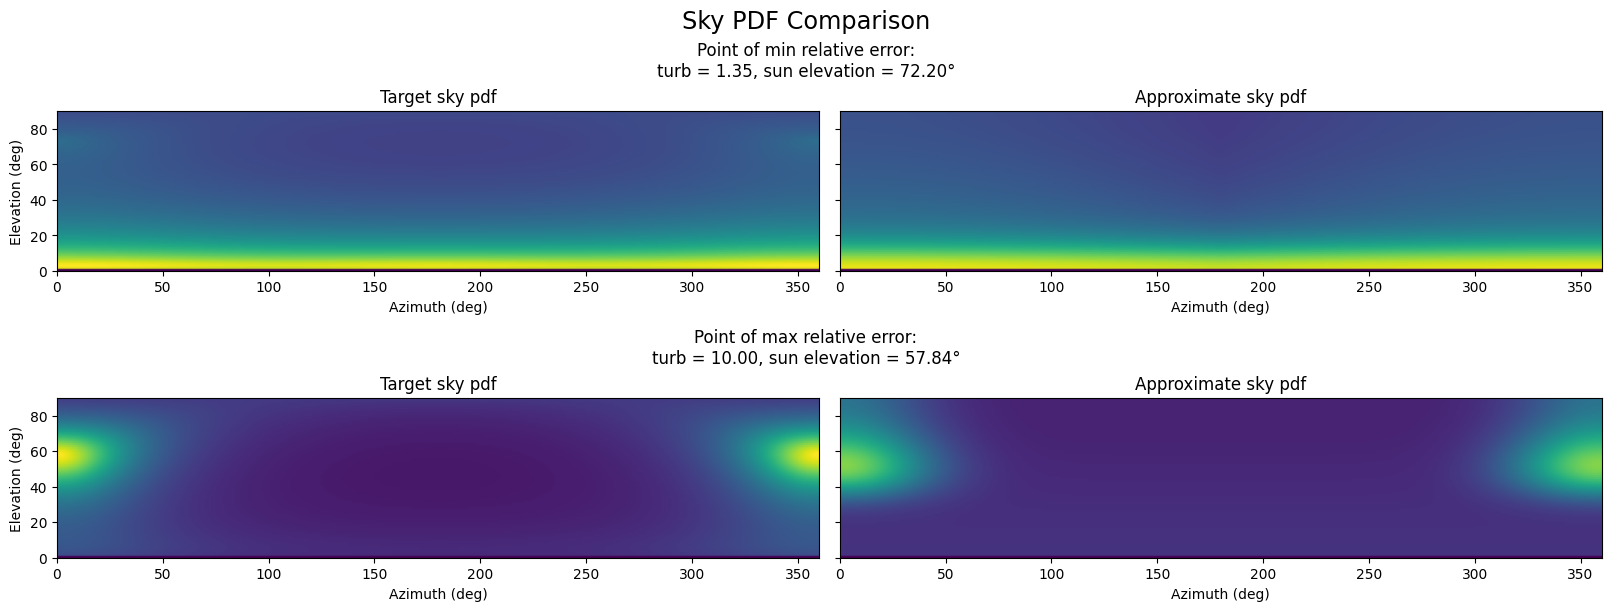

In [18]:
## PLOT THE MEAN RELATIVE ERROR OVER THE GRID
tgmm_weights = mi.tensor_io.read('../output/tgmm_tables.bin')['tgmm_tables']
tgmm_weights = mi.TensorXf(tgmm_weights)

with dr.scoped_set_flag(dr.JitFlag.Debug):
    pdf_funcs = {
        "Approximate PDF": (approximate_pdf, tex_weights),
        "Uniform PDF": (uniform_pdf, 0),
        "TGMM-based PDF": (tgmm_pdf, tgmm_weights)
    }
    plot_mre(pdf_funcs)


### SECOND PLOT THE WEIGHTS AND LOSSES PER GRIDPOINT
fig_weights = plot_weights(tex_weights)

### THIRD PLOT THE SKY PDFS FOR A CHOSEN GRIDPOINT
fig_pdfs = plt.figure(layout='constrained', figsize=(16,6))
subfigs_pdfs = fig_pdfs.subfigures(len(chosen_points), wspace=0.07)
for i, (chosen_point, plot_title) in enumerate(chosen_points):
    subfig = subfigs_pdfs[i] if isinstance(subfigs_pdfs, np.ndarray) else subfigs_pdfs
    plot_pdf(subfig, approximate_pdf, tex_weights, chosen_point)
    subfig.suptitle(plot_title, fontsize='large')
fig_pdfs.suptitle('Sky PDF Comparison', fontsize='xx-large')

plt.show()

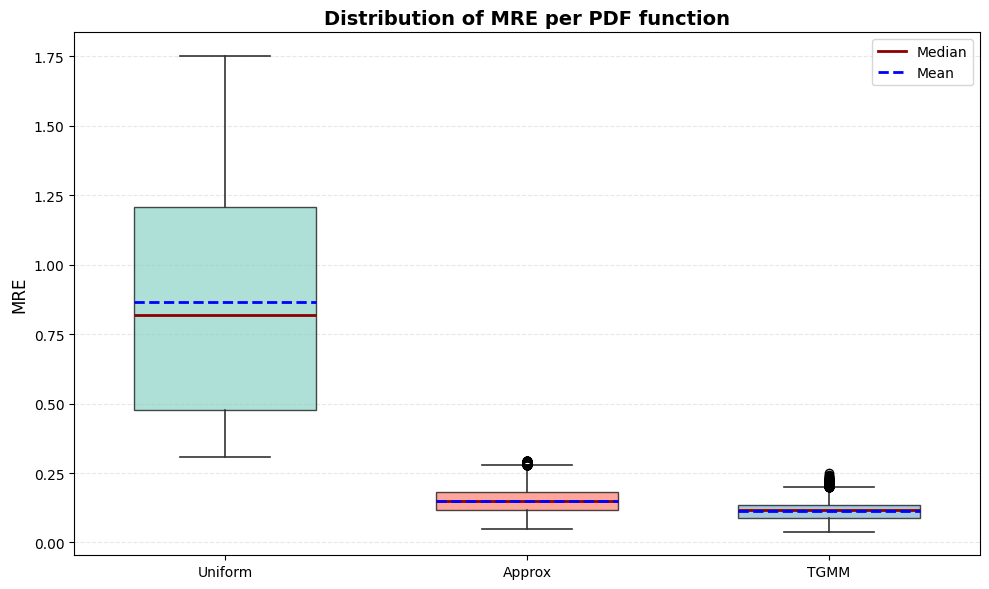

In [19]:
def plot_boxplots(list1, list2, list3, labels=['List 1', 'List 2', 'List 3'], title='Data Distribution Comparison'):
    """
    Creates boxplots to visualize the quantiles and extremes of three lists of values.
    
    Parameters:
    -----------
    list1, list2, list3 : array-like
        Three lists/arrays of numerical values to compare
    labels : list of str, optional
        Labels for the three datasets (default: ['List 1', 'List 2', 'List 3'])
    title : str, optional
        Title for the plot (default: 'Data Distribution Comparison')
    
    Returns:
    --------
    fig : matplotlib.figure.Figure
        The figure object containing the boxplots
    """
    # Convert to numpy arrays
    data = [np.array(list1), np.array(list2), np.array(list3)]
    
    # Create figure
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Create boxplot
    bp = ax.boxplot(data, tick_labels=labels, patch_artist=True, 
                     showmeans=True, meanline=True,
                     widths=0.6)
    
    # Customize colors
    colors = ['#8dd3c7', '#fb8072', '#80b1d3']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    # Customize other elements
    for element in ['whiskers', 'fliers', 'caps']:
        plt.setp(bp[element], color='#333333', linewidth=1.2)
    
    plt.setp(bp['medians'], color='darkred', linewidth=2)
    plt.setp(bp['means'], color='blue', linewidth=2, linestyle='--')
    
    # Add grid
    ax.yaxis.grid(True, alpha=0.3, linestyle='--')
    ax.set_axisbelow(True)
    
    # Labels and title
    ax.set_ylabel('MRE', fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold')
    
    # Add legend for median and mean lines
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], color='darkred', linewidth=2, label='Median'),
        Line2D([0], [0], color='blue', linewidth=2, linestyle='--', label='Mean')
    ]
    ax.legend(handles=legend_elements, loc='upper right')
    
    fig.tight_layout()


rel_err_tgmm = compute_mre_grid(
    tgmm_pdf,
    tgmm_weights, tex_pos, sky_rad, sky_params, norm_factor, sun_dir, env_map_wi, dr.width(env_map_wi)
)
rel_err_unif = compute_mre_grid(
    uniform_pdf,
    0, tex_pos, sky_rad, sky_params, norm_factor, sun_dir, env_map_wi, dr.width(env_map_wi)
)
plot_boxplots(rel_err_unif.array, rel_err_per_point.array, rel_err_tgmm.array, ['Uniform', 'Approx', 'TGMM'], title='Distribution of MRE per PDF function')

Average evaluation time over the grid:
 - Uniform PDF: 1.25 ms (ref)
 - Approximate PDF: 4.39 ms (3.51 x uniform)
 - TGMM-based PDF: 10.40 ms (8.31 x uniform)


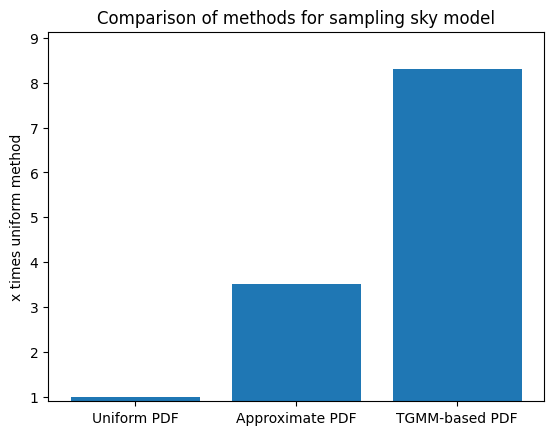

In [20]:
import time


def benchmark_pdf(pdf_func, tex_weights):
    mean_times = 0
    nb_iterations = 300
    for i in range(nb_iterations):

        start = time.time()

        res = accumulate_on_grid(
            lambda approx_pdf, target_pdf: approx_pdf,
            pdf_func,
            tex_weights, tex_pos, sky_rad, sky_params, norm_factor, sun_dir, env_map_wi, dr.width(env_map_wi)
        )

        dr.eval(res)
        dr.sync_thread()

        mean_times += time.time() - start

    mean_times /= nb_iterations
    return mean_times * 1000

approx_time = benchmark_pdf(approximate_pdf, tex_weights)
uniform_time = benchmark_pdf(uniform_pdf, 0)
tgmm_time = benchmark_pdf(tgmm_pdf, tgmm_weights)
rel_unif_approx = approx_time / uniform_time
rel_unif_tgmm = tgmm_time / uniform_time

print(f"Average evaluation time over the grid:")
print(f" - Uniform PDF: {uniform_time:.2f} ms (ref)")
print(f" - Approximate PDF: {approx_time:.2f} ms ({rel_unif_approx:.2f} x uniform)")
print(f" - TGMM-based PDF: {tgmm_time:.2f} ms ({rel_unif_tgmm:.2f} x uniform)")

plt.bar(['Uniform PDF', 'Approximate PDF', 'TGMM-based PDF'], [1, rel_unif_approx, rel_unif_tgmm])
plt.ylabel('x times uniform method')
plt.ylim(0.9, max(rel_unif_approx, rel_unif_tgmm) * 1.1)
plt.title('Comparison of methods for sampling sky model')
plt.show()
